# 02: Physics-Informed Neural Networks (PINNs)

**Exercise:** [![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/kks32-courses/sciml/blob/main/lectures/02-pinn/02-pinn-exercise.ipynb)
**Solution:** [![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/kks32-courses/sciml/blob/main/lectures/02-pinn/02-pinn.ipynb)

# Data-driven NN

Data-driven model training progress:   0%|          | 0/5000 [00:00<?, ?it/s]

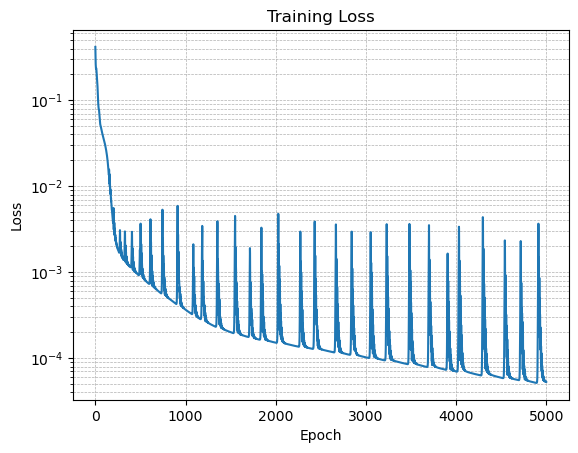

In [7]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# Define the standard neural network model
class StandardNN(nn.Module):
    def __init__(self):
        super(StandardNN, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(in_features=2, out_features=10),
            nn.Tanh(),
            nn.Linear(in_features=10, out_features=10),
            nn.Tanh(),
            nn.Linear(in_features=10, out_features=10),
            nn.Tanh(),
            nn.Linear(10, 1)
        )

    def forward(self, x, y):
        xy = torch.cat((x, y), dim=1)
        return self.layers(xy)

# Generate training data
x_data, y_data = np.meshgrid(np.linspace(-np.pi, np.pi, 50), np.linspace(-np.pi, np.pi, 50))
f_data = np.sin(x_data) * np.sin(y_data)
x_data, y_data, f_data = torch.tensor(x_data.flatten()).float().view(-1, 1), torch.tensor(y_data.flatten()).float().view(-1, 1), torch.tensor(f_data.flatten()).float().view(-1, 1)

# Define model
model = StandardNN()

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

losses = []

# Training loop
for epoch in tqdm(range(5000), desc='Data-driven model training progress'):
    optimizer.zero_grad()
    f_pred = model(x_data, y_data)
    loss = criterion(f_pred, f_data)
    loss.backward()
    optimizer.step()

    losses.append(loss.item())

# Plot the loss on a semilog scale
plt.figure()
plt.semilogy(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.show()

> 💡 When the loss function is non-smooth like the one shown here, it means we are probably using a higher learning rate. Try reducing the learning rate to 0.005 and 0.001 to see the effect on the loss evolution

## Test the data-driven model

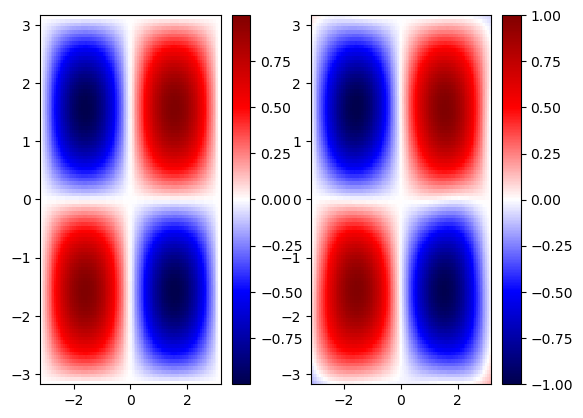

In [2]:
# Test the model
xyrange = 1 * np.pi
x_test, y_test = np.meshgrid(np.linspace(-xyrange, xyrange, 100), np.linspace(-xyrange, xyrange, 100))
f_test = np.sin(x_test) * np.sin(y_test)
x_test, y_test = torch.tensor(x_test).float().view(-1, 1), torch.tensor(y_test).float().view(-1, 1)
f_pred = model(x_test, y_test).detach().numpy().reshape(100, 100)

# Plotting
fig, ax = plt.subplots(1, 2)
im = ax[0].pcolor(x_test.numpy().reshape(100, 100), y_test.numpy().reshape(100, 100), f_test, cmap='seismic')
plt.colorbar(im, ax=ax[0])
im = ax[1].pcolor(x_test.numpy().reshape(100, 100), y_test.numpy().reshape(100, 100), f_pred, cmap='seismic')
plt.colorbar(im, ax=ax[1])
plt.show()

### Extrapolate outside training range

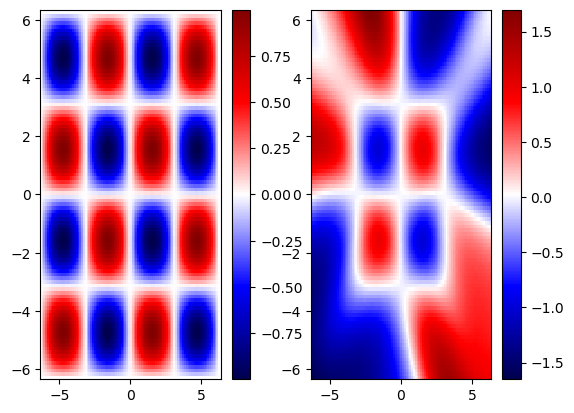

In [3]:
# Test the model
xyrange = 2 * np.pi
x_test, y_test = np.meshgrid(np.linspace(-xyrange, xyrange, 100), np.linspace(-xyrange, xyrange, 100))
f_test = np.sin(x_test) * np.sin(y_test)
x_test, y_test = torch.tensor(x_test).float().view(-1, 1), torch.tensor(y_test).float().view(-1, 1)
f_pred = model(x_test, y_test).detach().numpy().reshape(100, 100)

# Plotting
fig, ax = plt.subplots(1, 2)
im = ax[0].pcolor(x_test.numpy().reshape(100, 100), y_test.numpy().reshape(100, 100), f_test, cmap='seismic')
plt.colorbar(im, ax=ax[0])
im = ax[1].pcolor(x_test.numpy().reshape(100, 100), y_test.numpy().reshape(100, 100), f_pred, cmap='seismic')
plt.colorbar(im, ax=ax[1])
plt.show()

# PINNs

The Laplace equation is a second-order partial differential equation and is given by:

$$ \nabla^2 f = \frac{\partial^2 f}{\partial x^2} + \frac{\partial^2 f}{\partial y^2} = 0 $$

So, if you have $f(x,y) = \sin(x) \sin(y)$, you can plug it into the equation and calculate the second derivatives.

The second partial derivative with respect to $x$:

$$ \frac{\partial^2 f}{\partial x^2} = \frac{\partial}{\partial x} \left( \frac{\partial}{\partial x} \sin(x) \sin(y) \right) = \frac{\partial}{\partial x} \left( \cos(x) \sin(y) \right) = -\sin(x) \sin(y) $$

The second partial derivative with respect to $y$:

$$ \frac{\partial^2 f}{\partial y^2} = \frac{\partial}{\partial y} \left( \frac{\partial}{\partial y} \sin(x) \sin(y) \right) = \frac{\partial}{\partial y} \left( \sin(x) \cos(y) \right) = -\sin(x) \sin(y) $$

Putting it together, the Laplacian of $f$ is:

$$ \nabla^2 f = \frac{\partial^2 f}{\partial x^2} + \frac{\partial^2 f}{\partial y^2} = -\sin(x) \sin(y) - \sin(x) \sin(y) = -2 \sin(x) \sin(y) $$

So, the loss function for PINN is:

$$\mathcal{L} = \frac{\partial^2 f}{\partial x^2} + \frac{\partial^2 f}{\partial y^2} + 2 \sin(x) \sin(y)$$


Physics-informed model training progress:   0%|          | 0/5000 [00:00<?, ?it/s]

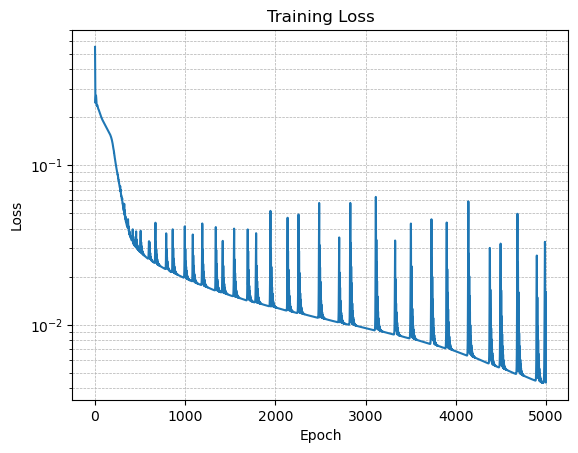

In [4]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# Define the PINN model
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(2, 10),
            nn.Tanh(),
            nn.Linear(10, 10),
            nn.Tanh(),
            nn.Linear(10, 10),
            nn.Tanh(),
            nn.Linear(10, 1)
        )

    def forward(self, x, y):
        xy = torch.cat((x, y), dim=1)
        return self.layers(xy)

    def loss_function(self, x, y):
        f = self.forward(x, y)
        f_x = torch.autograd.grad(f.sum(), x, create_graph=True)[0]
        f_xx = torch.autograd.grad(f_x.sum(), x, create_graph=True)[0]
        f_y = torch.autograd.grad(f.sum(), y, create_graph=True)[0]
        f_yy = torch.autograd.grad(f_y.sum(), y, create_graph=True)[0]

        pde_loss = f_xx + f_yy + 2 * f
        return torch.mean((f - torch.sin(x) * torch.sin(y))**2) + torch.mean(pde_loss**2)


# Generate training data
x_data, y_data = np.meshgrid(np.linspace(-np.pi, np.pi, 50), np.linspace(-np.pi, np.pi, 50))
x_data, y_data = torch.tensor(x_data.flatten(), requires_grad=True).float().view(-1, 1), torch.tensor(y_data.flatten(), requires_grad=True).float().view(-1, 1)

# Define model
model = PINN()

# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

losses = []

# Training loop
for pinn_epoch in tqdm(range(5000), desc='Physics-informed model training progress'):
    optimizer.zero_grad()
    loss = model.loss_function(x_data, y_data)
    loss.backward()
    optimizer.step()

    losses.append(loss.item())


# Plot the loss on a semilog scale
plt.figure()
plt.semilogy(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.show()


## Test the PINN model

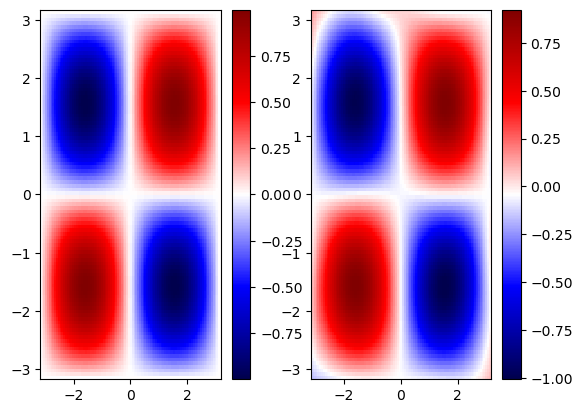

In [5]:
# Generate test data
xyrange = 1 * np.pi
x_test, y_test = np.meshgrid(np.linspace(-xyrange, xyrange, 100), np.linspace(-xyrange, xyrange, 100))
x_test, y_test = torch.tensor(x_test).float().view(-1, 1), torch.tensor(y_test).float().view(-1, 1)
f_test = (torch.sin(x_test) * torch.sin(y_test)).detach().numpy().reshape(100, 100)
f_pred = model(x_test, y_test).detach().numpy().reshape(100, 100)

# Plotting
fig, ax = plt.subplots(1, 2)
im = ax[0].pcolor(x_test.numpy().reshape(100, 100), y_test.numpy().reshape(100, 100), f_test, cmap='seismic')
plt.colorbar(im, ax=ax[0])
im = ax[1].pcolor(x_test.numpy().reshape(100, 100), y_test.numpy().reshape(100, 100), f_pred, cmap='seismic')
plt.colorbar(im, ax=ax[1])
plt.show()

### Extrapolate outside training regime

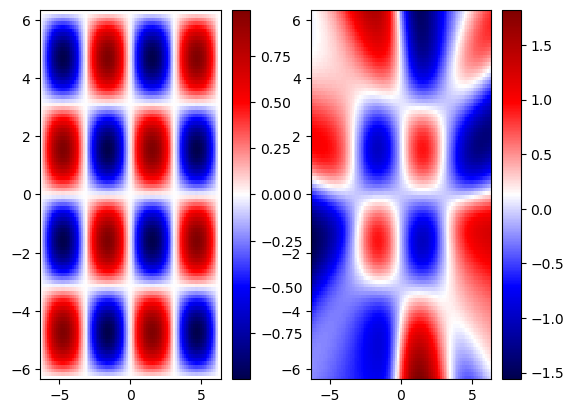

In [6]:
# Generate test data
xyrange = 2 * np.pi
x_test, y_test = np.meshgrid(np.linspace(-xyrange, xyrange, 100), np.linspace(-xyrange, xyrange, 100))
x_test, y_test = torch.tensor(x_test).float().view(-1, 1), torch.tensor(y_test).float().view(-1, 1)
f_test = (torch.sin(x_test) * torch.sin(y_test)).detach().numpy().reshape(100, 100)
f_pred = model(x_test, y_test).detach().numpy().reshape(100, 100)

# Plotting
fig, ax = plt.subplots(1, 2)
im = ax[0].pcolor(x_test.numpy().reshape(100, 100), y_test.numpy().reshape(100, 100), f_test, cmap='seismic')
plt.colorbar(im, ax=ax[0])
im = ax[1].pcolor(x_test.numpy().reshape(100, 100), y_test.numpy().reshape(100, 100), f_pred, cmap='seismic')
plt.colorbar(im, ax=ax[1])
plt.show()